In [34]:
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
def assign_interval(value):
    if value <= 100000:
        return 0
    elif value <= 350000:
        return 1
    else:
        return 2

In [36]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(27, 64)
        self.ac1 = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 32)
        self.layer4 = nn.Linear(32, 3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.layer1(x)
        x = self.ac1(x)
        x = self.bn1(x)

        x = self.dropout(x)
        x = self.layer2(x)
        x = self.ac1(x)
        x = self.bn2(x)

        x = self.dropout(x)
        x = self.layer3(x)
        x = self.ac1(x)
        x = self.bn3(x)

        x = self.dropout(x)
        x = self.layer4(x)

        return x


In [37]:
train_data = pd.read_csv('train_data.csv')

le = LabelEncoder()
train_data['TimeToBusStop'] = le.fit_transform(train_data['TimeToBusStop'])
train_data['TimeToSubway'] = le.fit_transform(train_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
train_data = pd.get_dummies(train_data, columns=ohe_cols).astype(float) # mozna drop first true

train_data['SalePrice'] = train_data['SalePrice'].apply(assign_interval)

In [41]:
X = train_data.drop('SalePrice', axis=1).values
y = train_data['SalePrice'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dataset = data.TensorDataset(torch.tensor(X_scaled).float(), torch.tensor(y).long())

In [45]:
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = data.Subset(dataset, train_indices)
test_dataset = data.Subset(dataset, test_indices)

train_labels = torch.tensor(y[train_indices]).long()
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()

class_weights = class_weights / class_weights.sum()
sampler = data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples=len(train_labels), replacement=True)

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True) # sampler=sampler
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [46]:
model = Classifier()
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
opt_bn = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 0, Loss: 0.7602852582931519
Epoch: 1, Loss: 0.6927293539047241
Epoch: 2, Loss: 0.5407853722572327
Epoch: 3, Loss: 0.6733099222183228
Epoch: 4, Loss: 0.7432907819747925
Epoch: 5, Loss: 0.5054075121879578
Epoch: 6, Loss: 0.5035961270332336
Epoch: 7, Loss: 0.4106866717338562
Epoch: 8, Loss: 0.4414134621620178
Epoch: 9, Loss: 0.3041246235370636
Epoch: 10, Loss: 0.3659447133541107
Epoch: 11, Loss: 0.5062256455421448
Epoch: 12, Loss: 0.38002750277519226
Epoch: 13, Loss: 0.43440136313438416
Epoch: 14, Loss: 0.394471138715744
Epoch: 15, Loss: 0.40024232864379883
Epoch: 16, Loss: 0.2705339193344116
Epoch: 17, Loss: 0.49547791481018066
Epoch: 18, Loss: 0.43741315603256226
Epoch: 19, Loss: 0.32240989804267883
Epoch: 20, Loss: 0.46189773082733154
Epoch: 21, Loss: 0.2869195342063904
Epoch: 22, Loss: 0.3688114881515503
Epoch: 23, Loss: 0.473294198513031
Epoch: 24, Loss: 0.31348803639411926
Epoch: 25, Loss: 0.25919926166534424
Epoch: 26, Loss: 0.3050331175327301
Epoch: 27, Loss: 0.373601853847

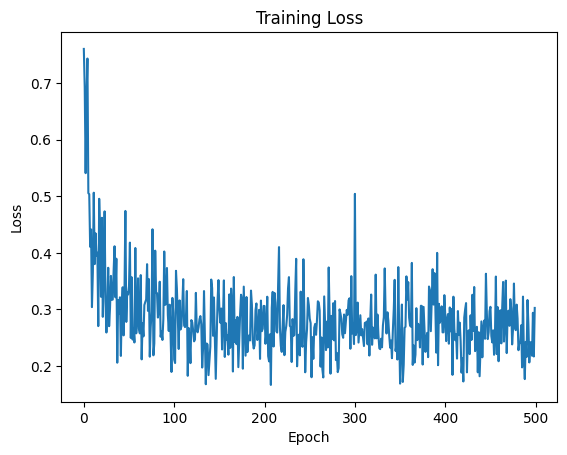

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []
model.train()
for epoch in range(500):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt_bn.zero_grad()
        y_pred = model(x)
        y = y.to("cpu")
        y_pred = y_pred.to("cpu")
        loss = criterion(y_pred, y)
        loss.backward()
        opt_bn.step()

    losses.append(loss.item())
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [48]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        y_pred_classes = torch.argmax(y_pred, dim=1)

        y_pred_list.extend(y_pred_classes.cpu().numpy().tolist())
        y_true_list.extend(y.cpu().numpy().tolist())

correct_predictions = sum([1 for i in range(len(y_pred_list)) if y_pred_list[i] == y_true_list[i]])
accuracy = (correct_predictions / len(y_pred_list)) * 100

print(f"Classification accuracy: {accuracy:.2f}%")


Classification accuracy: 86.06%


In [49]:
test_data = pd.read_csv("test_data.csv")

le = LabelEncoder()
test_data['TimeToBusStop'] = le.fit_transform(test_data['TimeToBusStop'])
test_data['TimeToSubway'] = le.fit_transform(test_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
test_data = pd.get_dummies(test_data, columns=ohe_cols).astype(float)

X_test = test_data.values
X_test_scaled = scaler.transform(X_test)

test_dataset = torch.tensor(X_test_scaled).float()

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = test_dataset.to(device)

model.eval()

with torch.no_grad():
    y_pred = model(test_dataset)
    y_pred_classes = torch.argmax(y_pred, dim=1)

In [53]:
predictions_df = pd.DataFrame(y_pred_classes.cpu().numpy())
predictions_df.to_csv('pred.csv', index=False, header=False)